![My Logo](./LandingAI_Logo.svg)

---

# LandingAI Agentic Document Extraction (ADE) Example
## Background
This notebook demonstrates how to analyze an example - AI-generated - Know Your Customer (KYC) document using LandingAI's Agentic Document Extraction tool. It showcases both REST API and Python SDK methods, along with visualization tools provided by LandingAI. The notebook also includes an integration with OpenAI for field extraction and question answering, as well as an evaluation pipeline powered by LangChain.

## End-to-End Steps:
1. Package Installs
2. Imports, Example Document Visualization, and Models Instantiation
    - Copy `.env.example` to `.env` and add your API keys for LandingAI Vision Agent and OpenAI
3. Document Extraction Methods: LandingAI ADE REST API and LandingAI ADE Python SDK
    - LandingAI ADE REST API Method + Processing Time
    - LandingAI ADE Python SDK Method + Processing Time
    - Visualization Methods
        - Grounding Overlay
        - Markdown
        - Chunks
    - Field Extraction using OpenAI
        - Example of Extracting the Compliance Contact and Their Email Address
        - Example of Requirement Verification: Forms Required
4. Evaluation Pipeline using LangChain and OpenAI
    - Convert the LandingAI Chunks to LangChain Documents
    - Instantiate the OpenAI Embedding Model, Store the Embeddings in a Vectorstore and Create a Retriever
    - Create a QA Chain and Instantiate an OpenAI model for Evaluation
    - Create an Evaluation Dataset
    - Run Predictions
    - Evaluate the Answers using FAISS (Facebook AI Similarity Search)
    - Show the Results
    - Repeat with AI-Generated Questions - Using LLMs for Evaluation

### Setup Instructions:
1. Copy `.env.example` to `.env`
2. Add your `VISION_AGENT_API_KEY` and `OPENAI_API_KEY` to the `.env` file
---

In [ ]:
# ---
# LandingAI Applied AI Content Notebook Template
# ---
# Title:  ADE_LLM_Extraction
# Author: David Park
# Description: Streamlined notebook for using LLMs for extracting information
# Target Audience: [Developers, Partners, Customers]
# Content Type: [Tutorial, How-To]
# Publish Date: 2025-09-30
# ADE Version: v0.3.3
# Change Log:
#    - v1.0: Initial Notebook
# ---

# 1. Package Installs

In [ ]:
# Pip install or use the requirements.txt file
pip install agentic-doc python-dotenv openai langchain langchain-community langchain-openai faiss-cpu

---

# 2. Imports, Example Document Visualization, and Models Instantiation

In [2]:
# Standard Imports
import requests
import os
import re
import time
import openai
import json
import matplotlib.pyplot as plt
from pprint import pprint
from IPython.display import Markdown, display, IFrame
from PIL import Image
from dotenv import load_dotenv

# LandingAI ADE Python SDK 
from agentic_doc.parse import parse
from agentic_doc.utils import viz_parsed_document
from agentic_doc.config import VisualizationConfig

# Langchain for the evaluation pipeline
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.evaluation.qa import QAEvalChain

# Load environment variables from .env file
load_dotenv()

# Get API keys from environment variables
VISION_AGENT_API_KEY = os.getenv("VISION_AGENT_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Rest API Endpoint for ADE
url = "https://api.va.landing.ai/v1/tools/agentic-document-analysis"

# Instantiate the client object from OpenAI
client = openai.OpenAI(api_key=OPENAI_API_KEY)

# Loading the document example
kyc_doc = './KYC_EXAMPLE_DOC.pdf'

2025-09-30 13:00:19 [info   ] Settings loaded: {
  "endpoint_host": "https://api.va.landing.ai",
  "vision_agent_api_key": "dzhra[REDACTED]",
  "batch_size": 4,
  "max_workers": 5,
  "max_retries": 3,
  "max_retry_wait_time": 60,
  "retry_logging_style": "log_msg",
  "pdf_to_image_dpi": 96,
  "split_size": 10,
  "extraction_split_size": 50
} [agentic_doc.config] (config.py:172)


In [3]:
# Visualize the sample Know Your Customer (KCYC) document (PDF)
IFrame(kyc_doc, width=800, height=1200)

---

# 3. Document Extraction Methods

## LandingAI ADE Rest API Method + Processing Time

In [4]:
start_time = time.time()
files = {
  # "image": open("{{file_1}}", "rb")
  # OR, for PDF
  "pdf": open(kyc_doc, "rb")
}
headers = {
  "Authorization": f"Basic {VISION_AGENT_API_KEY}",
}
response = requests.post(url, files=files, headers=headers)
end_time = time.time()

print(response.json())
print('-----------------------------------------')
print(f"Doc processing took {end_time - start_time:.4f} seconds using LandingAI's ADE Rest API.")

{'data': {'markdown': 'KYC DOCUMENT - INSTITUTIONAL CLIENT\n\nClient Name: Acme Global Holdings Ltd.\nRegistration Number: 123456789\nIncorporation Date: January 15, 2012\nCountry of Incorporation: United Kingdom\nLegal Entity Identifier: 5493001KJTIIGC8Y1R12\nTax Identification No.: GB123456789\nRegistered Address: 123 Finance Street\nLondon, EC1A 1AA\nUnited Kingdom\n\nOperating Address: 456 Business Avenue\nCanary Wharf, London, E14 5AB\nUnited Kingdom\n\nNature of Business: Investment Holdings\nIndustry Sector: Financial Services\nAuthorized Signatory: Jane Doe\nChief Financial Officer\njane.doe@acmeglobal.com\n+44 20 7946 1234\n\nCompliance Contact: John Smith\ncompliance@acmeglobal.com\n+44 20 7946 5678\n\nOwnership Structure: [X] Publicly Listed\nStock Exchange: London Stock Exchange\nTicker Symbol: ACME.L\n\nRequired Attachments: [X] Certificate of Incorporation\n[X] Proof of Registered Address\n[X] Authorized Signatory ID Copy\n[X] Company Ownership Chart\n[X] FATCA/CRS Self-C

## LandingAI ADE Python SDK Method + Processing Time

The Visual Grounding images will be saved to the path specified for the "grounding_save_dir" parameter where the output path: grounding_save_dir/document_TIMESTAMP/page_X/CHUNK_ID_Y.png
- X is the page number, CHUNK_ID is the unique ID of each chunk
- Y is the index of the grounding within the chunk

In [5]:
# Parse a local file
result = parse(kyc_doc, grounding_save_dir="./groundings")
parsed_doc = result[0]

# Get the extracted data as markdown
print("Extracted Markdown:")
print(result[0].markdown)

print("\n" + "="*80 + "\n")

# Get the extracted data as structured chunks of content in a JSON schema
print("Extracted Chunks:")
print(result[0].chunks)

print("\n" + "="*80 + "\n")

# Each chunk's grounding in the result will have the image_path set
for chunk in result[0].chunks:
    for grounding in chunk.grounding:
        if grounding.image_path:
            print(f"Grounding saved to: {grounding.image_path}")

2025-09-30 13:00:45 [info   ] API key is valid.              [agentic_doc.utils] (utils.py:42)
2025-09-30 13:00:45 [info   ] Parsing 1 documents            [agentic_doc.parse] (parse.py:280)
2025-09-30 13:00:45 [info   ] Splitting PDF: 'KYC_EXAMPLE_DOC.pdf' into 0 parts under '/var/folders/_0/xg_50ybj0bs8yjqd5wjj40h40000gn/T/tmpnwmk9l32' [agentic_doc.utils] (utils.py:238)
2025-09-30 13:00:45 [info   ] Created /var/folders/_0/xg_50ybj0bs8yjqd5wjj40h40000gn/T/tmpnwmk9l32/KYC_EXAMPLE_DOC_1.pdf [agentic_doc.utils] (utils.py:254)
2025-09-30 13:00:45 [info   ] Start parsing document part: 'File name: KYC_EXAMPLE_DOC_1.pdf	Page: [0:1]' [agentic_doc.parse] (parse.py:671)


Parsing documents:   0%|          | 0/1 [00:00<?, ?it/s]

HTTP Request: POST https://api.va.landing.ai/v1/tools/agentic-document-analysis "HTTP/1.1 200 OK" (_client.py:1025)
2025-09-30 13:00:55 [info   ] Time taken to successfully parse a document chunk: 10.11 seconds [agentic_doc.parse] (parse.py:827)
2025-09-30 13:00:55 [info   ] Successfully parsed document part: 'File name: KYC_EXAMPLE_DOC_1.pdf	Page: [0:1]' [agentic_doc.parse] (parse.py:680)


Parsing document parts from 'KYC_EXAMPLE_DOC.pdf': 100%|██████████| 1/1 [00:10<00:00, 10.11s/it]

2025-09-30 13:00:55 [info   ] Saving 8 chunks as images to 'groundings/KYC_EXAMPLE_DOC_20250930_130055' [agentic_doc.utils] file_path=PosixPath('KYC_EXAMPLE_DOC.pdf') file_type=pdf (utils.py:82)



Parsing documents: 100%|██████████| 1/1 [00:10<00:00, 10.22s/it]

Extracted Markdown:
KYC DOCUMENT - INSTITUTIONAL CLIENT

Client Name: Acme Global Holdings Ltd.
Registration Number: 123456789
Incorporation Date: January 15, 2012
Country of Incorporation: United Kingdom
Legal Entity Identifier: 5493001KJTIIGC8Y1R12
Tax Identification No.: GB123456789
Registered Address: 123 Finance Street
London, EC1A 1AA
United Kingdom

Operating Address: 456 Business Avenue
Canary Wharf, London, E14 5AB
United Kingdom

Nature of Business: Investment Holdings
Industry Sector: Financial Services
Authorized Signatory: Jane Doe
Chief Financial Officer
jane.doe@acmeglobal.com
+44 20 7946 1234

Compliance Contact: John Smith
compliance@acmeglobal.com
+44 20 7946 5678

Ownership Structure: [X] Publicly Listed
Stock Exchange: London Stock Exchange
Ticker Symbol: ACME.L

Required Attachments: [X] Certificate of Incorporation
[X] Proof of Registered Address
[X] Authorized Signatory ID Copy
[X] Company Ownership Chart
[X] FATCA/CRS Self-Certification Form <!-- text, from page

## Vizualization Methods

### Grounding Overlay

In [6]:
# Create visualizations with default settings
# The output images have a PIL.Image.Image type
images = viz_parsed_document(
    kyc_doc,
    parsed_doc,
    output_dir="./visualizations"
)

# Or customize the visualization appearance
# viz_config = VisualizationConfig(
#     thickness=2,  # Thicker bounding boxes
#     text_bg_opacity=0.8,  # More opaque text background
#     font_scale=0.7,  # Larger text
#     # Custom colors for different chunk types
#     color_map={
#         ChunkType.TITLE: (0, 0, 255),  # Red for titles
#         ChunkType.TEXT: (255, 0, 0),  # Blue for regular text
#         # ... other chunk types ...
#     }
# )

2025-09-30 13:01:00 [info   ] Visualizing parsed document of: 'KYC_EXAMPLE_DOC.pdf' [agentic_doc.utils] (utils.py:307)


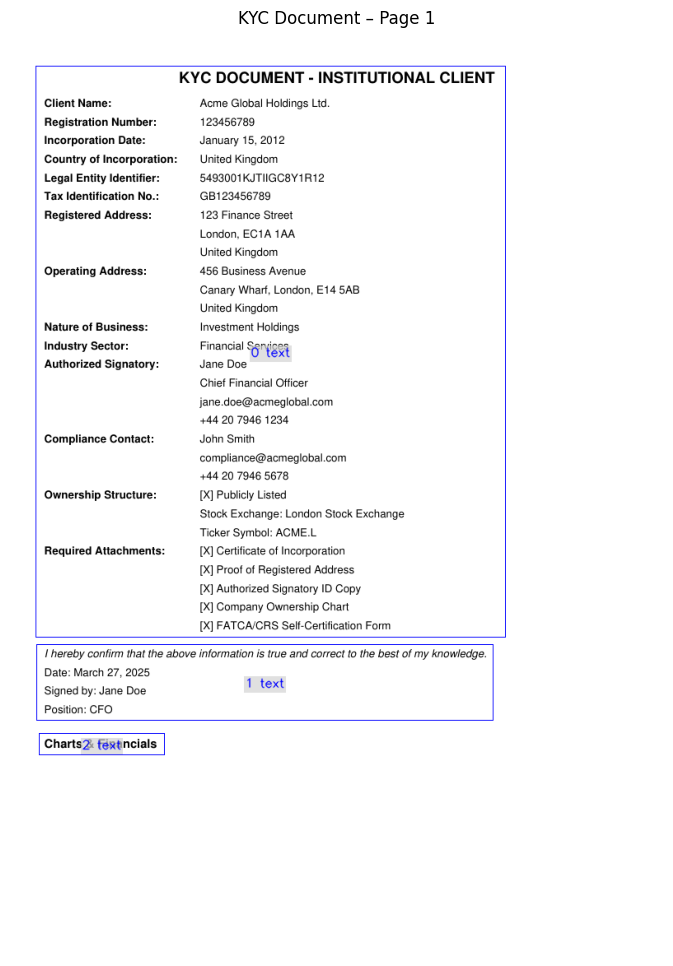

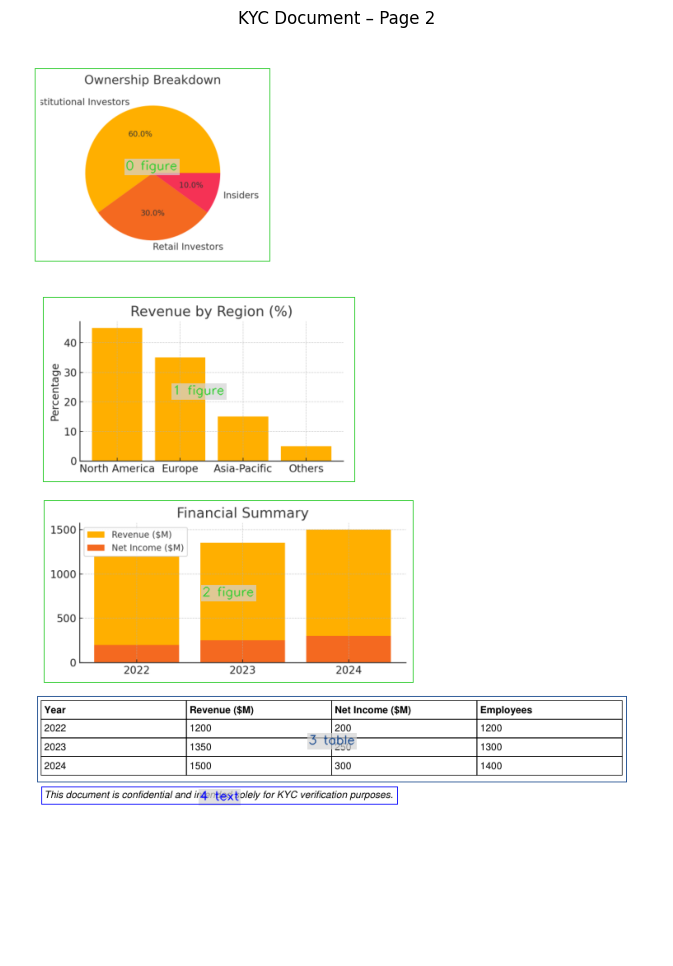

In [7]:
# Load visualizations (make sure the paths are correct)
page1_path = "./visualizations/KYC_EXAMPLE_DOC_viz_page_0.png"
page2_path = "./visualizations/KYC_EXAMPLE_DOC_viz_page_1.png"

# Open images
visual_grounding_image_page1 = Image.open(page1_path)
visual_grounding_image_page2 = Image.open(page2_path)

# Define a display function
def show_image(image, title=None):
    plt.figure(figsize=(10, 12))
    if title:
        plt.title(title)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Display
show_image(visual_grounding_image_page1, "KYC Document – Page 1")
show_image(visual_grounding_image_page2, "KYC Document – Page 2")

### Markdown Visualization

In [8]:
display(Markdown(parsed_doc.markdown))

KYC DOCUMENT - INSTITUTIONAL CLIENT

Client Name: Acme Global Holdings Ltd.
Registration Number: 123456789
Incorporation Date: January 15, 2012
Country of Incorporation: United Kingdom
Legal Entity Identifier: 5493001KJTIIGC8Y1R12
Tax Identification No.: GB123456789
Registered Address: 123 Finance Street
London, EC1A 1AA
United Kingdom

Operating Address: 456 Business Avenue
Canary Wharf, London, E14 5AB
United Kingdom

Nature of Business: Investment Holdings
Industry Sector: Financial Services
Authorized Signatory: Jane Doe
Chief Financial Officer
jane.doe@acmeglobal.com
+44 20 7946 1234

Compliance Contact: John Smith
compliance@acmeglobal.com
+44 20 7946 5678

Ownership Structure: [X] Publicly Listed
Stock Exchange: London Stock Exchange
Ticker Symbol: ACME.L

Required Attachments: [X] Certificate of Incorporation
[X] Proof of Registered Address
[X] Authorized Signatory ID Copy
[X] Company Ownership Chart
[X] FATCA/CRS Self-Certification Form <!-- text, from page 0 (l=0.040,t=0.037,r=0.756,b=0.654), with ID ff97ef47-ab07-4db4-aa3c-1734dddf046b -->

*I hereby confirm that the above information is true and correct to the best of my knowledge.*

Date: March 27, 2025  
Signed by: Jane Doe  
Position: CFO <!-- text, from page 0 (l=0.041,t=0.663,r=0.737,b=0.744), with ID 0ce694a5-d235-41b3-8642-03c8dd1942d0 -->

Charts & Financials <!-- text, from page 0 (l=0.045,t=0.759,r=0.235,b=0.782), with ID b97cab76-c0bc-4b8b-b7f3-ac162e8346a9 -->

Summary : This figure presents a pie chart showing the breakdown of ownership among three groups: Institutional Investors, Retail Investors, and Insiders, with their respective percentage shares.

pie chart:
Title & Labels :
  • Title: "Ownership Breakdown"
  • Slice labels: "Institutional Investors", "Retail Investors", "Insiders"
  • Percentage values displayed: 60.0%, 30.0%, 10.0%
  • No axis labels (pie chart format)

Data Points :
  • Institutional Investors: 60.0%
  • Retail Investors: 30.0%
  • Insiders: 10.0%

Design Encodings :
  • Institutional Investors: large yellow-orange slice (top left)
  • Retail Investors: medium orange slice (bottom)
  • Insiders: small red slice (right)
  • Each slice labeled with its percentage
  • Slice labels placed around the pie, with "Institutional Investors" text slightly cropped at the left edge

Distribution & Trends :
  • Ownership is dominated by Institutional Investors (60.0%)
  • Retail Investors hold a significant minority (30.0%)
  • Insiders have a small share (10.0%)

Analysis :
  • The majority of ownership is concentrated with Institutional Investors, who control more than half of the total.
  • Retail Investors make up nearly one-third, while Insiders have a minimal stake.
  • The chart visually emphasizes the dominance of Institutional Investors in the ownership structure. <!-- figure, from page 1 (l=0.038,t=0.040,r=0.396,b=0.247), with ID c1e1c3f9-e65d-40bf-93e0-d73aa247a33e -->

Summary : This bar chart shows the percentage of revenue generated by different regions, with North America leading, followed by Europe, Asia-Pacific, and Others.

bar chart:
# Title & Axes :
  • Title: "Revenue by Region (%)"
  • X-axis label: Region (categories: North America, Europe, Asia-Pacific, Others)
  • Y-axis label: Percentage
  • Y-axis tick labels: 0, 10, 20, 30, 40, 50

# Data Points :
  • North America: approximately 45%
  • Europe: approximately 35%
  • Asia-Pacific: approximately 15%
  • Others: approximately 5%

# Design Encodings :
  • All bars are colored orange.
  • No error bars or additional series.
  • Simple vertical bar chart.

# Distribution & Trends :
  • Revenue is highest in North America, followed by Europe.
  • Asia-Pacific and Others contribute significantly less.

# Analysis :
  • The data shows a strong concentration of revenue in North America and Europe, with North America being the dominant region.
  • Asia-Pacific and Others together account for less than a quarter of the total revenue, indicating a regional imbalance in revenue generation. <!-- figure, from page 1 (l=0.052,t=0.287,r=0.526,b=0.486), with ID f3a4167a-8775-4c59-bbc1-972e1783ccb2 -->

Summary : This figure presents a bar chart summarizing financial performance over three years, showing both revenue and net income in millions of dollars.

bar chart:
Title & Axes :
  • Title: "Financial Summary".
  • X-axis: Years (2022, 2023, 2024).
  • Y-axis: Value in millions of dollars ($M), with tick marks at 0, 500, 1000, and 1500.

Data Points :
  • Revenue ($M) (orange bars):
      – 2022: approximately 1200
      – 2023: approximately 1350
      – 2024: approximately 1500
  • Net Income ($M) (darker orange/red bars, stacked on top of revenue):
      – 2022: approximately 200
      – 2023: approximately 250
      – 2024: approximately 300

Design Encodings :
  • Revenue ($M): orange fill.
  • Net Income ($M): darker orange/red fill, stacked on top of revenue.
  • Legend at upper left with color swatches for each series.
  • Gridlines present for easier value estimation.

Distribution & Trends :
  • Both revenue and net income increase each year from 2022 to 2024.
  • The gap between revenue and net income remains consistent, with both metrics rising in parallel.

Analysis :
  • The company’s financial performance shows steady year-over-year growth in both revenue and net income from 2022 to 2024.
  • The proportional increase in net income suggests profitability is keeping pace with revenue growth. <!-- figure, from page 1 (l=0.052,t=0.507,r=0.615,b=0.703), with ID c1bc1f4a-ad9e-44ee-8bef-1042951142c8 -->

<table><thead><tr><th>Year</th><th>Revenue ($M)</th><th>Net Income ($M)</th><th>Employees</th></tr></thead><tbody><tr><td>2022</td><td>1200</td><td>200</td><td>1200</td></tr><tr><td>2023</td><td>1350</td><td>250</td><td>1300</td></tr><tr><td>2024</td><td>1500</td><td>300</td><td>1400</td></tr></tbody></table> <!-- table, from page 1 (l=0.042,t=0.719,r=0.942,b=0.811), with ID f832f7ce-5ba3-4ddf-b6aa-b4d523594521 -->

*This document is confidential and intended solely for KYC verification purposes.* <!-- text, from page 1 (l=0.049,t=0.817,r=0.591,b=0.835), with ID e17dec05-f9be-4e03-b0ca-40a38d1b0439 -->

### Chunks

In [9]:
print(parsed_doc.chunks)  # Get the extracted data as structured chunks of content

[Chunk(text='KYC DOCUMENT - INSTITUTIONAL CLIENT\n\nClient Name: Acme Global Holdings Ltd.\nRegistration Number: 123456789\nIncorporation Date: January 15, 2012\nCountry of Incorporation: United Kingdom\nLegal Entity Identifier: 5493001KJTIIGC8Y1R12\nTax Identification No.: GB123456789\nRegistered Address: 123 Finance Street\nLondon, EC1A 1AA\nUnited Kingdom\n\nOperating Address: 456 Business Avenue\nCanary Wharf, London, E14 5AB\nUnited Kingdom\n\nNature of Business: Investment Holdings\nIndustry Sector: Financial Services\nAuthorized Signatory: Jane Doe\nChief Financial Officer\njane.doe@acmeglobal.com\n+44 20 7946 1234\n\nCompliance Contact: John Smith\ncompliance@acmeglobal.com\n+44 20 7946 5678\n\nOwnership Structure: [X] Publicly Listed\nStock Exchange: London Stock Exchange\nTicker Symbol: ACME.L\n\nRequired Attachments: [X] Certificate of Incorporation\n[X] Proof of Registered Address\n[X] Authorized Signatory ID Copy\n[X] Company Ownership Chart\n[X] FATCA/CRS Self-Certificati

## Field Extraction using OpenAI

### Example of Extracting the Compliance Contact and Their Email Address 

In [10]:
markdown_text = parsed_doc.markdown

prompt = f"""
Here is some structured markdown content:

{markdown_text}

Please extract the compliance contact and their email in the following JSON format:
{{"name": "", "email": ""}} 
"""

response = client.chat.completions.create(
    model="gpt-4o",  # aka "o3-mini"
    messages=[
        {"role": "user", "content": prompt}
    ],
    temperature=0.0
)

# Expected answers: "John Smith" & "compliance@acmeglobal.com"
print(response.choices[0].message.content)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)
```json
{
  "name": "John Smith",
  "email": "compliance@acmeglobal.com"
}
```


### Example of Requirement Verification: Validating Missing Required Forms 

In [11]:
markdown_text = parsed_doc.markdown

prompt = f"""
Here is some structured markdown content:

{markdown_text}

Are there any missing required attachments? Please answer yes or no:
"""

response = client.chat.completions.create(
    model="gpt-4o",  # aka "o3-mini"
    messages=[
        {"role": "user", "content": prompt}
    ],
    temperature=0.0
)

# Expected answers: "No missing forms"
print(response.choices[0].message.content)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)
No, there are no missing required attachments. All the required attachments listed in the document are marked as provided.


---

# 4. Evaluation Pipeline using LangChain and OpenAI

## Convert the LandingAI Chunks to LangChain Documents

In [12]:
def chunks_to_documents(chunks):
    docs = []
    for chunk in chunks:
        metadata = {
            "chunk_id": chunk.chunk_id,
            "chunk_type": chunk.chunk_type.value,
            "page": chunk.grounding[0].page if chunk.grounding else None
        }
        docs.append(Document(page_content=chunk.text, metadata=metadata))
    return docs

documents = chunks_to_documents(parsed_doc.chunks)

In [13]:
print(documents)

[Document(metadata={'chunk_id': 'ff97ef47-ab07-4db4-aa3c-1734dddf046b', 'chunk_type': 'text', 'page': 0}, page_content='KYC DOCUMENT - INSTITUTIONAL CLIENT\n\nClient Name: Acme Global Holdings Ltd.\nRegistration Number: 123456789\nIncorporation Date: January 15, 2012\nCountry of Incorporation: United Kingdom\nLegal Entity Identifier: 5493001KJTIIGC8Y1R12\nTax Identification No.: GB123456789\nRegistered Address: 123 Finance Street\nLondon, EC1A 1AA\nUnited Kingdom\n\nOperating Address: 456 Business Avenue\nCanary Wharf, London, E14 5AB\nUnited Kingdom\n\nNature of Business: Investment Holdings\nIndustry Sector: Financial Services\nAuthorized Signatory: Jane Doe\nChief Financial Officer\njane.doe@acmeglobal.com\n+44 20 7946 1234\n\nCompliance Contact: John Smith\ncompliance@acmeglobal.com\n+44 20 7946 5678\n\nOwnership Structure: [X] Publicly Listed\nStock Exchange: London Stock Exchange\nTicker Symbol: ACME.L\n\nRequired Attachments: [X] Certificate of Incorporation\n[X] Proof of Regist

## Instantiate the OpenAI Embeddings Model, Store the Embeddings in a Vectorstore and Create a Retriever

In [14]:
# OpenAI's Embedding Model
embedding_model = OpenAIEmbeddings(api_key=OPENAI_API_KEY)

# Vectorstore using FAISS
vectorstore = FAISS.from_documents(documents, embedding_model)

# Vectorstore Retriever
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3})

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK" (_client.py:1025)
Loading faiss. (loader.py:148)
Successfully loaded faiss. (loader.py:150)
Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes. (__init__.py:173)


## Create a QA Chain and Instantiate an OpenAI Model for Evaluation

In [15]:
# OpenAI LLM
llm = ChatOpenAI(api_key=OPENAI_API_KEY, model="gpt-4o", temperature=0)

# QA Chain
qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever, return_source_documents=True)

## Create an Evaluation Dataset

### You can also use LLMs to generate your evaluation questions and answers!

In [16]:
eval_questions = [
    {
        "query": "What is the client's name?",
        "answer": "Acme Global Holdings Ltd."
    },
    {
        "query": "Are there any missing required attachments? Please answer yes or no.",
        "answer": "No"
    },
    {
        "query": "What is the breakdown of the ownership and which investors \
        have the highest ownership percentage?",
        "answer": "Institutional investors own 60%, insiders own 10%, and \
        retail investors own 30%. Institutional investors have the highest \
        percent ownership."
    },
    {
        "query": "What is the email address for compliance contact?",
        "answer": "compliance@acmeglobal.com"
    },
    {
        "query": "What region has the lowest revenue?",
        "answer": "Others"
    },
    {
        "query": "What is the YoY growth % for revenue?",
        "answer": "12.5% from 2022 to 2023 and 11.11% from 2023 to 2024."
    }
]

## Run Predictions 

In [17]:
predictions = []
for q in eval_questions:
    result = qa_chain.invoke({"query": q["query"]})
    predictions.append({
        "question": q["query"],
        "predicted_answer": result["result"],
        "ground_truth": q["answer"]
    })

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/embed

## Evaluate the Answers Using FAISS (Facebook AI Similarity Search)

In [18]:
eval_chain = QAEvalChain.from_llm(llm)
graded_outputs = eval_chain.evaluate(
    examples=[{"query": p["question"], "answer": p["ground_truth"]} for p in predictions],
    predictions=[{"query": p["question"], "result": p["predicted_answer"]} for p in predictions]
)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)


## Show the Results

In [19]:
for i, (pred, grade) in enumerate(zip(predictions, graded_outputs)):
    print(f"\nQ{i+1}: {pred['question']}")
    print(f"Prediction: {pred['predicted_answer']}")
    print(f"Ground Truth: {pred['ground_truth']}")

    score = grade.get("results", "No score")
    # print result
    print(f"Grade: {score}")



Q1: What is the client's name?
Prediction: The client's name is Acme Global Holdings Ltd.
Ground Truth: Acme Global Holdings Ltd.
Grade: CORRECT

Q2: Are there any missing required attachments? Please answer yes or no.
Prediction: I don't know.
Ground Truth: No
Grade: INCORRECT

Q3: What is the breakdown of the ownership and which investors         have the highest ownership percentage?
Prediction: The breakdown of ownership is as follows: Institutional Investors hold 60.0%, Retail Investors hold 30.0%, and Insiders hold 10.0%. Institutional Investors have the highest ownership percentage at 60.0%.
Ground Truth: Institutional investors own 60%, insiders own 10%, and         retail investors own 30%. Institutional investors have the highest         percent ownership.
Grade: CORRECT

Q4: What is the email address for compliance contact?
Prediction: The email address for the compliance contact is compliance@acmeglobal.com.
Ground Truth: compliance@acmeglobal.com
Grade: CORRECT

Q5: What 

## Repeat with AI-Generated Questions - Using LLMs for Evaluation

In [ ]:
# Fill in the number of evaluation questions you want to test
num_questions = 10

prompt = f"""
Extract {num_questions} factual question-answer pairs from the following KYC document. Return them as a Python list of dictionaries in this format:

eval_questions_updated = [
    {{
        "query": "What is the client's name?",
        "answer": "Acme Global Holdings Ltd."
    }},
    ...
]

Here is the document:
\"\"\"
{markdown_text}
\"\"\"
"""

response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": "You are an investment analyst that extracts structured Q&A pairs from KYC documents."},
        {"role": "user", "content": prompt}
    ],
    temperature=0
)

raw_text = response.choices[0].message.content

# Find the Python list inside a code block
code_block_match = re.search(r"eval_questions_updated\s*=\s*(\[[\s\S]+\])", raw_text)

if code_block_match:
    eval_questions_llm = eval(code_block_match.group(1))
else:
    print("Could not parse eval_questions from response:")
    print(raw_text)
    eval_questions_llm = []

pprint(eval_questions_llm)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)
[{'answer': 'Acme Global Holdings Ltd.', 'query': "What is the client's name?"},
 {'answer': '123456789',
  'query': 'What is the registration number of the client?'},
 {'answer': 'January 15, 2012', 'query': 'When was the client incorporated?'},
 {'answer': 'United Kingdom',
  'query': 'In which country is the client incorporated?'},
 {'answer': '5493001KJTIIGC8Y1R12',
  'query': 'What is the Legal Entity Identifier of the client?'},
 {'answer': 'GB123456789',
  'query': 'What is the tax identification number of the client?'},
 {'answer': '123 Finance Street, London, EC1A 1AA, United Kingdom',
  'query': 'What is the registered address of the client?'},
 {'answer': 'Jane Doe',
  'query': 'Who is the authorized signatory for the client?'},
 {'answer': 'Investment Holdings',
  'query': "What is the nature of the client's business?"},
 {'answer': 'ACME.L',
  'query': 'What is the ticker symb

In [23]:
predictions_llm = []
for q in eval_questions_llm:
    result = qa_chain.invoke({"query": q["query"]})
    predictions_llm.append({
        "question": q["query"],
        "predicted_answer": result["result"],
        "ground_truth": q["answer"]
    })

HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/embed

In [24]:
print(predictions_llm)

[{'question': "What is the client's name?", 'predicted_answer': "The client's name is Acme Global Holdings Ltd.", 'ground_truth': 'Acme Global Holdings Ltd.'}, {'question': 'What is the registration number of the client?', 'predicted_answer': 'The registration number of the client, Acme Global Holdings Ltd., is 123456789.', 'ground_truth': '123456789'}, {'question': 'When was the client incorporated?', 'predicted_answer': 'The client, Acme Global Holdings Ltd., was incorporated on January 15, 2012.', 'ground_truth': 'January 15, 2012'}, {'question': 'In which country is the client incorporated?', 'predicted_answer': 'The client, Acme Global Holdings Ltd., is incorporated in the United Kingdom.', 'ground_truth': 'United Kingdom'}, {'question': 'What is the legal entity identifier of the client?', 'predicted_answer': 'The legal entity identifier of the client, Acme Global Holdings Ltd., is 5493001KJTII8C8Y1R12.', 'ground_truth': '5493001KJTII8C8Y1R12'}, {'question': 'What is the register

In [25]:
eval_chain_llm = QAEvalChain.from_llm(llm)
graded_outputs_llm = eval_chain_llm.evaluate(
    examples=[{"query": p["question"], "answer": p["ground_truth"]} for p in predictions],
    predictions=[{"query": p["question"], "result": p["predicted_answer"]} for p in predictions]
)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK" (_client.py:1025)


In [26]:
for i, (pred, grade) in enumerate(zip(predictions_llm, graded_outputs_llm)):
    print(f"\nQ{i+1}: {pred['question']}")
    print(f"Prediction: {pred['predicted_answer']}")
    print(f"Ground Truth: {pred['ground_truth']}")

    score = grade.get("results", "No score")
    # print result
    print(f"Grade: {score}")



Q1: What is the client's name?
Prediction: The client's name is Acme Global Holdings Ltd.
Ground Truth: Acme Global Holdings Ltd.
Grade: CORRECT

Q2: What is the registration number of the client?
Prediction: The registration number of the client, Acme Global Holdings Ltd., is 123456789.
Ground Truth: 123456789
Grade: INCORRECT

Q3: When was the client incorporated?
Prediction: The client, Acme Global Holdings Ltd., was incorporated on January 15, 2012.
Ground Truth: January 15, 2012
Grade: CORRECT

Q4: In which country is the client incorporated?
Prediction: The client, Acme Global Holdings Ltd., is incorporated in the United Kingdom.
Ground Truth: United Kingdom
Grade: CORRECT

Q5: What is the legal entity identifier of the client?
Prediction: The legal entity identifier of the client, Acme Global Holdings Ltd., is 5493001KJTII8C8Y1R12.
Ground Truth: 5493001KJTII8C8Y1R12
Grade: CORRECT

Q6: What is the registered address of the client?
Prediction: The registered address of the clien